In [1]:
# import standard libraries
from  dateutil import relativedelta
import math
import regex as re
from glob import glob
import numpy as np
import random
# third-party libraries
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
# local libraries
from fbd import read_parquet, get_monthly_returns

In [2]:
num_days = 252

In [3]:
# get some data first
# get fama
fama = pd.read_csv('data/fama/fama.csv.gz', compression='gzip', index_col=0)/100

In [4]:
# get annualized risk free rate
rf = fama['RF']+1
rf = rf.cumprod()
ann_rf = rf.iloc[-1]**(num_days/len(rf))-1

In [5]:
# choose cluster method
cluster_method = ['kmeans', 'agglomerative_ward', 
                  'meanshift', 'spectral']

# choose factor model
num_feat = [3, 5, 6, 8]

# cost
cost = 0 #0.3/10000 # in basis points

# Get data and plot

In [6]:
# read results
returns = {n: {} for n in num_feat}
capital = {n: {} for n in num_feat}

In [7]:
for n in num_feat:
    for c in cluster_method:
        res = pd.read_csv(f'data/strategy/{n}_factor/{c}_{int(math.ceil(cost*1e6))}.gz',
                          compression='gzip', index_col=0)
        returns[n][c] = res

        # do cumulative returns from a capital of 1$
        cap = res + 1
        # add bogus date with 1 at the beginnninng
        cap = pd.concat([pd.DataFrame(columns=cap.columns, index=['2010-01-31'], data=1), cap], 
                            axis=0, 
                            ignore_index=False)
        cap = cap.cumprod()
        cap.index = pd.to_datetime(cap.index)
        capital[n][c] = cap

In [8]:
# compute metrics
# annualized returns
ann_ret = pd.DataFrame(index=pd.MultiIndex.from_product([num_feat, cluster_method],
                                                       names=['factor model', 'algorithm']), 
                       columns=['best cluster', 'worse cluster', 'Russell 3000', 'random strategy',
                               'market'])

# annualized standard deviation
ann_std = ann_ret.copy()
# annualized sharpe ratio
ann_sr = ann_ret.copy()
overall_ret = ann_ret.copy()

for n in num_feat:
    for c in cluster_method:
        ann_ret_n_c = capital[n][c].iloc[-1]**(num_days/len(capital[n][c]))-1
        ann_ret.at[n, c] = ann_ret_n_c
        
        ann_std_n_c = returns[n][c].std()*np.sqrt(num_days)
        ann_std.at[n, c] = ann_std_n_c
        
        ann_sr.at[n, c] = (ann_ret_n_c - ann_rf)/ann_std_n_c
        
        overall_ret.at[n, c] = capital[n][c].iloc[-1]/capital[n][c].iloc[0]

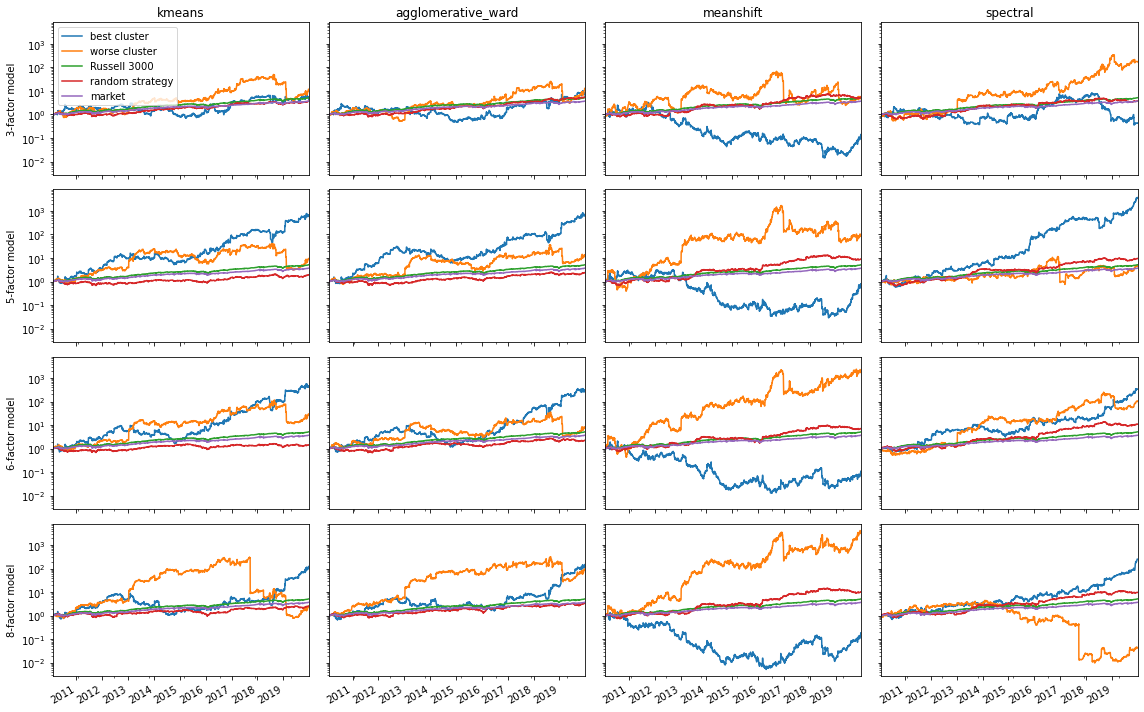

In [9]:
fig, ax = plt.subplots(figsize=(16, 10), nrows=4, ncols=4, sharex=True, sharey=True)
for n_i, n in enumerate(num_feat):
    for c_i, c in enumerate(cluster_method):
        title = None
        ylabel = None
        if n_i == 0:
            title = c
        if c_i == 0:
            ylabel = f'{n}-factor model'
        
        lines = capital[n][c].plot(ax=ax[n_i, c_i], title=title)
        ax[n_i, c_i].set_yscale('log')
        ax[n_i, c_i].set_xlim(capital[n][c].index[0], capital[n][c].index[-1])
        ax[n_i, c_i].set_ylabel(ylabel)
        if c_i != 0 or n_i != 0:
            ax[n_i, c_i].get_legend().remove()
plt.tight_layout()

## Some correlations

In [10]:
n = 8
best_meanshift = returns[n]['meanshift']['best cluster']
worse_meanshift = returns[n]['meanshift']['worse cluster']
pd.concat([best_meanshift, worse_meanshift], axis=1).corr()

,best cluster,worse cluster
best cluster,1.000000,0.023975
worse cluster,0.023975,1.000000


# Tables

In [11]:
ann_ret = ann_ret.astype(float).round(3)
ann_ret

best cluster  worse cluster  Russell 3000  \
factor model algorithm                                                       
3            kmeans                     0.160          0.271          0.18   
             agglomerative_ward         0.205          0.286          0.18   
             meanshift                 -0.177          0.174          0.18   
             spectral                  -0.082          0.682          0.18   
5            kmeans                     0.928          0.248          0.18   
             agglomerative_ward         0.932          0.297          0.18   
             meanshift                 -0.025          0.572          0.18   
             spectral                   1.284          0.165          0.18   
6            kmeans                     0.842          0.392          0.18   
             agglomerative_ward         0.777          0.228          0.18   
             meanshift                 -0.208          1.126          0.18   
             spectral                   0.798          0.592          0.18   
8            kmeans                     0.620          0.087          0.18   
             agglomerative_ward         0.655          0.571          0.18   
             meanshift                 -0.165          1.266          0.18   
             spectral                   0.746         -0.271          0.18   

                                 random strategy  market  
factor model algorithm                                    
3            kmeans                        0.141   0.141  
             agglomerative_ward            0.189   0.141  
             meanshift                     0.186   0.141  
             spectral                      0.143   0.141  
5            kmeans                        0.069   0.141  
             agglomerative_ward            0.092   0.141  
             meanshift                     0.247   0.141  
             spectral                      0.256   0.141  
6            kmeans                        0.037   0.141  
             agglomerative_ward            0.085   0.141  
             meanshift                     0.219   0.141  
             spectral                      0.274   0.141  
8            kmeans                        0.102   0.141  
             agglomerative_ward            0.132   0.141  
             meanshift                     0.264   0.141  
             spectral                      0.257   0.141

In [12]:
ann_std = ann_std.astype(float).round(3)
ann_std

best cluster  worse cluster  Russell 3000  \
factor model algorithm                                                       
3            kmeans                     0.814          0.697         0.162   
             agglomerative_ward         0.809          0.745         0.162   
             meanshift                  1.127          1.184         0.162   
             spectral                   0.850          1.005         0.162   
5            kmeans                     0.894          0.760         0.162   
             agglomerative_ward         0.891          0.791         0.162   
             meanshift                  1.162          1.265         0.162   
             spectral                   0.795          0.767         0.162   
6            kmeans                     0.894          0.889         0.162   
             agglomerative_ward         0.887          0.754         0.162   
             meanshift                  1.186          1.243         0.162   
             spectral                   0.777          0.882         0.162   
8            kmeans                     0.870          1.030         0.162   
             agglomerative_ward         0.867          0.977         0.162   
             meanshift                  1.210          1.269         0.162   
             spectral                   0.737          0.800         0.162   

                                 random strategy  market  
factor model algorithm                                    
3            kmeans                        0.208   0.152  
             agglomerative_ward            0.212   0.152  
             meanshift                     0.318   0.152  
             spectral                      0.298   0.152  
5            kmeans                        0.230   0.152  
             agglomerative_ward            0.229   0.152  
             meanshift                     0.333   0.152  
             spectral                      0.291   0.152  
6            kmeans                        0.230   0.152  
             agglomerative_ward            0.250   0.152  
             meanshift                     0.339   0.152  
             spectral                      0.298   0.152  
8            kmeans                        0.251   0.152  
             agglomerative_ward            0.262   0.152  
             meanshift                     0.332   0.152  
             spectral                      0.297   0.152

In [13]:
ann_sr = ann_sr.astype(float).round(3)
ann_sr

best cluster  worse cluster  Russell 3000  \
factor model algorithm                                                       
3            kmeans                     0.190          0.381         1.077   
             agglomerative_ward         0.247          0.377         1.077   
             meanshift                 -0.162          0.142         1.077   
             spectral                  -0.102          0.673         1.077   
5            kmeans                     1.032          0.319         1.077   
             agglomerative_ward         1.040          0.369         1.077   
             meanshift                 -0.026          0.448         1.077   
             spectral                   1.608          0.209         1.077   
6            kmeans                     0.935          0.435         1.077   
             agglomerative_ward         0.870          0.296         1.077   
             meanshift                 -0.180          0.902         1.077   
             spectral                   1.020          0.665         1.077   
8            kmeans                     0.707          0.079         1.077   
             agglomerative_ward         0.749          0.579         1.077   
             meanshift                 -0.141          0.994         1.077   
             spectral                   1.006         -0.346         1.077   

                                 random strategy  market  
factor model algorithm                                    
3            kmeans                        0.655   0.893  
             agglomerative_ward            0.869   0.893  
             meanshift                     0.568   0.893  
             spectral                      0.463   0.893  
5            kmeans                        0.278   0.893  
             agglomerative_ward            0.379   0.893  
             meanshift                     0.728   0.893  
             spectral                      0.860   0.893  
6            kmeans                        0.140   0.893  
             agglomerative_ward            0.320   0.893  
             meanshift                     0.630   0.893  
             spectral                      0.903   0.893  
8            kmeans                        0.386   0.893  
             agglomerative_ward            0.483   0.893  
             meanshift                     0.778   0.893  
             spectral                      0.850   0.893

In [14]:
overall_ret = overall_ret.astype(float).round(3)
overall_ret

best cluster  worse cluster  Russell 3000  \
factor model algorithm                                                       
3            kmeans                     4.354         10.741          5.16   
             agglomerative_ward         6.364         12.079          5.16   
             meanshift                  0.144          4.892          5.16   
             spectral                   0.428        173.019          5.16   
5            kmeans                   669.752          8.956          5.16   
             agglomerative_ward       684.111         13.151          5.16   
             meanshift                  0.779         88.507          5.16   
             spectral                3594.566          4.563          5.16   
6            kmeans                   425.600         26.471          5.16   
             agglomerative_ward       298.268          7.685          5.16   
             meanshift                  0.099       1768.097          5.16   
             spectral                 335.038        100.461          5.16   
8            kmeans                   119.635          2.281          5.16   
             agglomerative_ward       147.089         87.952          5.16   
             meanshift                  0.167       3326.825          5.16   
             spectral                 251.489          0.043          5.16   

                                 random strategy  market  
factor model algorithm                                    
3            kmeans                        3.706   3.696  
             agglomerative_ward            5.578   3.696  
             meanshift                     5.405   3.696  
             spectral                      3.775   3.696  
5            kmeans                        1.939   3.696  
             agglomerative_ward            2.392   3.696  
             meanshift                     8.937   3.696  
             spectral                      9.560   3.696  
6            kmeans                        1.438   3.696  
             agglomerative_ward            2.249   3.696  
             meanshift                     7.121   3.696  
             spectral                     11.013   3.696  
8            kmeans                        2.620   3.696  
             agglomerative_ward            3.405   3.696  
             meanshift                    10.183   3.696  
             spectral                      9.684   3.696

In [15]:
print(overall_ret.to_latex(index=True)) 

\begin{tabular}{llrrrrr}
\toprule
  &          &  best cluster &  worse cluster &  Russell 3000 &  random strategy &  market \\
factor model & algorithm &               &                &               &                  &         \\
\midrule
3 & kmeans &         4.354 &         10.741 &          5.16 &            3.706 &   3.696 \\
  & agglomerative\_ward &         6.364 &         12.079 &          5.16 &            5.578 &   3.696 \\
  & meanshift &         0.144 &          4.892 &          5.16 &            5.405 &   3.696 \\
  & spectral &         0.428 &        173.019 &          5.16 &            3.775 &   3.696 \\
5 & kmeans &       669.752 &          8.956 &          5.16 &            1.939 &   3.696 \\
  & agglomerative\_ward &       684.111 &         13.151 &          5.16 &            2.392 &   3.696 \\
  & meanshift &         0.779 &         88.507 &          5.16 &            8.937 &   3.696 \\
  & spectral &      3594.566 &          4.563 &          5.16 &            9.56

# With costs


In [16]:
res_2 = pd.read_csv(f'data/strategy/{5}_factor/spectral_{2}.gz',
                          compression='gzip', index_col=0)
res_0 = pd.read_csv(f'data/strategy/{5}_factor/spectral_{0}.gz',
                          compression='gzip', index_col=0)

res_0.rename(columns={'best cluster': 'best cluster no costs',
                     'worse cluster': 'worse cluster no costs'}, inplace=True)

res_2.rename(columns={'best cluster': 'best cluster with costs',
                     'worse cluster': 'worse cluster with costs'}, inplace=True)

In [17]:
with_costs = pd.concat([res_0, res_2[['best cluster with costs', 'worse cluster with costs']]], axis=1)
with_costs += 1
with_costs = with_costs.cumprod()

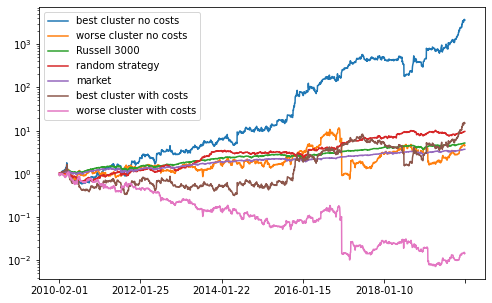

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
with_costs.plot(ax=ax)
ax.set_yscale('log')